In [8]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import warnings

warnings.filterwarnings("ignore")

In [9]:
hn = 64 #hidden state dim

class Model(nn.Module):
     
    def __init__(self, N):
        super().__init__()
        self.N = N
        self.stepLength = 2        
        self.hidden_initial = nn.Parameter(torch.empty(1, hn).normal_(mean=0, std=1)) #make inital hidden trainable
        self.hidden = self.hidden_initial.repeat((self.N, 1))  
        
        self.Whh = nn.Linear(hn, hn)
        self.Whx = nn.Linear(1, hn, bias = False)
        
        self.layer1 = nn.Linear(1, 64)
        self.layer2 = nn.Linear(64, hn)
        self.layer3 = nn.Linear(hn, hn)
        self.layer4 = nn.Linear(hn, 1)
        
  
    
    def forward_DNN(self, x):
        """Approximate wave function"""
        
        #concatenate hidden state to input of DNN
        #if self.hidden.shape[0] == x.shape[0]:
        #    y = torch.cat((self.hidden, x), 1)
        #else:
        #    y = torch.cat((self.hidden[0].repeat(x.shape[0], 1), x), 1)
            
        y = torch.tanh(self.layer1(x))
        y = torch.tanh(self.layer2(y))*self.hidden
        y = torch.tanh(self.layer3(y))
        y = self.layer4(y)
     
        return y
    
    
    def forward_RNN(self, x):
        """Encode correlation in hidden state"""
        self.hidden = torch.tanh(self.Whh(self.hidden) + self.Whx(x))
    
    
    def sample(self, N, n):
        total = 0
        x = torch.Tensor(4*np.random.random((N,1)) - 2)
        psi_old = self.forward_DNN(x)
        
        for i in range(n):
            x_new = x + self.stepLength*torch.Tensor(2*np.random.random((N,1)) - 1)
            psi_new = self.forward_DNN(x_new)
            
            idx = (psi_new/psi_old)**2 > torch.Tensor(np.random.random((N,1)))
            
            
            x[idx] = x_new[idx]
            psi_old[idx] = psi_new[idx]
            total += torch.sum(idx)
            
        return x, total
    
    def resetHidden(self, N=0):
        if N == 0: N = self.N
        self.hidden = self.hidden_initial.repeat((N, 1))

In [10]:
N = 5000 #Batch size
n = 10  #Metropolis step
h = 0.01

torch.manual_seed(42)
np.random.seed(42)
model = Model(N)
optimizer = torch.optim.Adam(model.parameters())

### Training

In [11]:
epochs = 2000

for epoch in tqdm(range(epochs)):
    PE_acc = 0
    P_acc = 0
    E_acc = 0
        
    model.resetHidden() 
    x1 = model.sample(N, n)[0].detach() #sample N positions for first particle
    psi1 = model.forward_DNN(x1)
    
    model.forward_RNN(x1)               #Advance hidden state based on previous sampled positions
    x2 = model.sample(N, n)[0].detach() #Sample positions for second particle, corrolated with first particle
    psi2 = model.forward_DNN(x2)        
    
    psi_total = psi1*psi2               #Total wave function
    
    
    #Numerical laplacian
    model.resetHidden()
    psi1_plus = model.forward_DNN(x1+h) #Change particle 1 coordinate, holding particle 2 constant. 
    model.forward_RNN(x1+h)           #however, psi2 still changes because of corrolation
    psi2_plus = model.forward_DNN(x2)
    
    model.resetHidden()
    psi1_minus = model.forward_DNN(x1-h)
    model.forward_RNN(x1 - h)
    psi2_minus = model.forward_DNN(x2)

    lap1 = 1/psi_total*(psi1_plus*psi2_plus - 2*psi_total + psi1_minus*psi2_minus)/h**2
    
    model.resetHidden()
    model.forward_RNN(x1)
    psi2_plus = model.forward_DNN(x2+h) #Change particle 2 coordinate, holding particle 1 constant.
    psi2_minus = model.forward_DNN(x2-h)
    
    lap2 = 1/psi2*(psi2_plus - 2*psi2 + psi2_minus)/h**2    #psi1 factor here, since it is constant
    

    E_L = (-0.5*(lap1 + lap2) + 0.5*(x1**2 + x2**2) + 1/torch.sqrt((x1 - x2)**2 + 0.1**2)).detach()

    PE = torch.mean(torch.log(psi_total)*E_L)
    P  = torch.mean(torch.log(psi_total))
    E  = torch.mean(E_L)  
    
    loss = 2*(PE - P*E)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    
    if epoch%100 == 0: 
        print(f"epoch: {epoch}, Energy: {E.item()}")

epoch: 0, Energy: 13.867956161499023
epoch: 100, Energy: 3.134580373764038
epoch: 200, Energy: 3.085866689682007
epoch: 300, Energy: 2.9974920749664307
epoch: 400, Energy: 3.0106682777404785
epoch: 500, Energy: 2.862800359725952
epoch: 600, Energy: 2.980201244354248
epoch: 700, Energy: 2.752120018005371
epoch: 800, Energy: 2.7345693111419678
epoch: 900, Energy: 2.6492741107940674
epoch: 1000, Energy: 2.663769245147705
epoch: 1100, Energy: 2.6458234786987305
epoch: 1200, Energy: 2.6510846614837646
epoch: 1300, Energy: 2.6246235370635986
epoch: 1400, Energy: 2.601755142211914
epoch: 1500, Energy: 2.607555627822876
epoch: 1600, Energy: 2.591341972351074
epoch: 1700, Energy: 2.618914842605591
epoch: 1800, Energy: 2.6432974338531494
epoch: 1900, Energy: 2.587520122528076



In [12]:
def f(x):
    x_lin = torch.linspace(-8, 8, N).reshape(N,-1)
    dx = x_lin[1] - x_lin[0] 
    model.resetHidden()
    psi1 = model.forward_DNN(x_lin)[:,0].detach().numpy()

    x = torch.Tensor([[x]])
    
    model.forward_RNN(x)
    psi2 = model.forward_DNN(x_lin)[:,0].detach().numpy()

    plt.plot(x_lin[:,0], 1/dx*psi1**2/np.sum(psi1**2), "b")
    plt.plot(x_lin[:,0], 1/dx*psi2**2/np.sum(psi2**2), "r")
    plt.plot(x, 0.01, "bo")
    plt.ylim((0, 0.8))

    plt.show()
    
def g(x):
    model.resetHidden()

    x = torch.Tensor([[x]])

    plt.plot(model.hidden[0].detach().numpy(), "bo")
    model.forward_RNN(x)

    plt.plot(model.hidden[0].detach().numpy(), "ro")
    plt.ylim((-1, 1))

    plt.show()

interact(f, x=(-4.0, 4., 0.05));
interact(g, x=(-4.0, 4., 0.1));

interactive(children=(FloatSlider(value=0.0, description='x', max=4.0, min=-4.0, step=0.05), Output()), _dom_c…

interactive(children=(FloatSlider(value=0.0, description='x', max=4.0, min=-4.0), Output()), _dom_classes=('wi…

### Check metropolis sampling

In [6]:
N = 100000
model.resetHidden()
x_lin = torch.linspace(-3, 3, 100).reshape(100,-1)
dx = x_lin[1] - x_lin[0]

model.forward_RNN(torch.Tensor([[0.4]]))
psi = model.forward_DNN(x_lin)[:,0].detach().numpy()

x = model.sample(N, 10)[0].detach().numpy()

bins = np.linspace(-3, 3, 100)
plt.hist(x, bins=bins)
plt.plot(x_lin[:,0], N*psi**2/np.sum(psi**2), "r")
plt.show()

RuntimeError: The size of tensor a (100) must match the size of tensor b (5000) at non-singleton dimension 0

## Estimating energy

In [13]:
N = 100000

model.resetHidden(N) 
x1 = model.sample(N, n)[0].detach() #sample N positions for first particle
psi1 = model.forward_DNN(x1)

model.forward_RNN(x1)               #Advance hidden state based on previous sampled positions
x2 = model.sample(N, n)[0].detach() #Sample positions for second particle, corrolated with first particle
psi2 = model.forward_DNN(x2)        

psi_total = psi1*psi2               #Total wave function

#Numerical laplacian
model.resetHidden(N)
psi1_plus = model.forward_DNN(x1+h) #Change particle 1 coordinate, holding particle 2 constant. 
model.forward_RNN(x1 + h)           #however, psi2 still changes because of corrolation
psi2_plus = model.forward_DNN(x2)

model.resetHidden(N)
psi1_minus = model.forward_DNN(x1-h)
model.forward_RNN(x1 - h)
psi2_minus = model.forward_DNN(x2)

lap1 = 1/psi_total*(psi1_plus*psi2_plus - 2*psi_total + psi1_minus*psi2_minus)/h**2

model.resetHidden(N)
model.forward_RNN(x1)
psi2_plus = model.forward_DNN(x2+h) #Change particle 2 coordinate, holding particle 1 constant.
psi2_minus = model.forward_DNN(x2-h)

lap2 = 1/psi2*(psi2_plus - 2*psi2 + psi2_minus)/h**2    #psi1 factor here, since it is constant


E = (-0.5*(lap1 + lap2) + 0.5*(x1**2 + x2**2) + 1/torch.sqrt((x1 - x2)**2 + 0.1**2))
E = torch.mean(E)
print(E.item())

x = torch.cat((x1, x2), 0).numpy()

2.5921294689178467


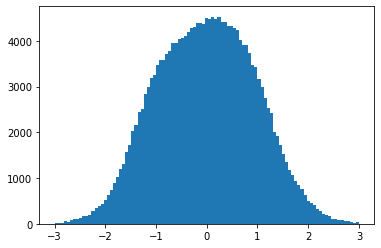

In [14]:
bins = np.linspace(-3, 3, 100)

plt.hist(x, bins=bins)
plt.show()